In [1]:
import numpy as np
import pickle as rick
import matplotlib.pyplot as plt
import matplotlib
import astropy.units as u
from astropy.table import Table
from astropy.io import fits
import scipy.stats as sps
import matplotlib.colors as colors
import scipy
import os
import datetime as dt

In [2]:
import sys
from os.path import dirname
sys.path.append("C://Users/cody2/Binary Project/pybay")
import bayli

In [3]:
lmc = rick.load(open("lmc-r13-l33-58672.pck", 'rb'))
smc = rick.load(open("smc-r13-l33-58672.pck", 'rb'))

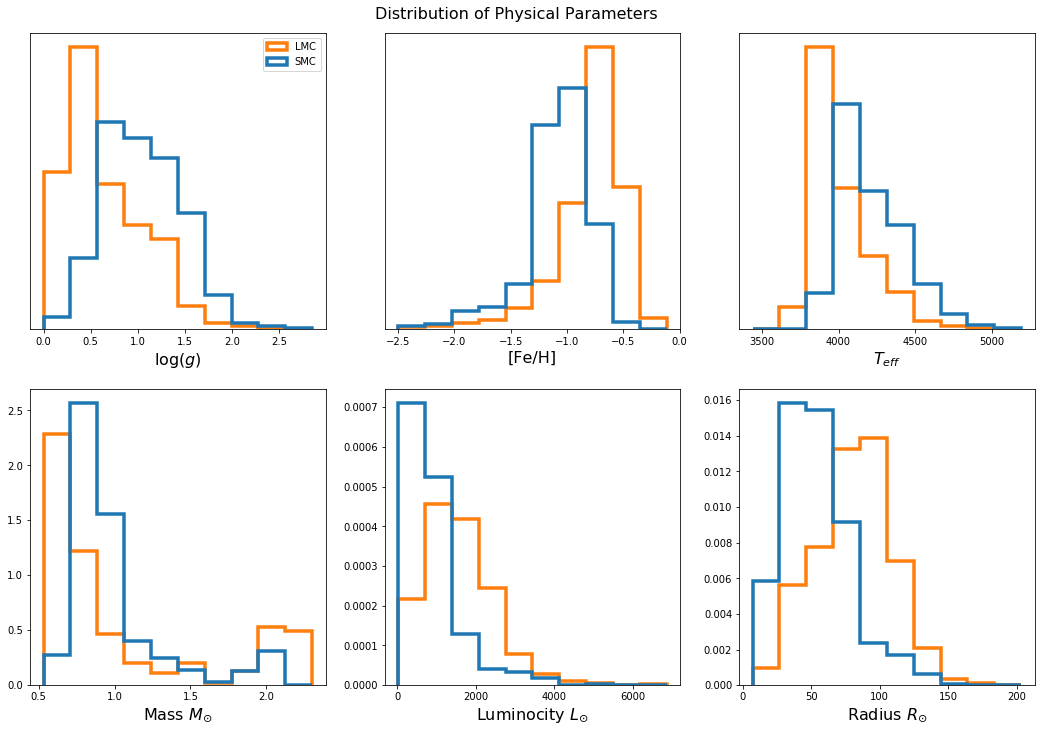

In [4]:
fig, ax = plt.subplots(2, 3, figsize = (18,12))
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)

ax[0][0].hist([smc['LOGG'], lmc['LOGG']],
           histtype='step',
           density= True,
           linewidth = 3.5,
           label = ["SMC", "LMC"])
ax[0][1].hist([smc['FE_H'], lmc['FE_H']],
           histtype='step',
           density= True,
           linewidth = 3.5)
ax[0][2].hist([smc['TEFF'], lmc['TEFF']],
           histtype='step',
           density= True,
           linewidth = 3.5)

ax[1][0].hist([smc['ISO_MASS'], lmc['ISO_MASS']],
           histtype='step',
           density= True,
           linewidth = 3.5,
           label = ["SMC", "LMC"])
ax[1][1].hist([smc['ISO_LUM'], lmc['ISO_LUM']],
           histtype='step',
           density= True,
           linewidth = 3.5)
ax[1][2].hist([smc['ISO_RAD'], lmc['ISO_RAD']],
           histtype='step',
           density= True,
           linewidth = 3.5)

ax[0][0].legend()

ax[0][0].set_xlabel("$\log(g)$", size = 16)
ax[0][1].set_xlabel("[Fe/H]", size = 16)
ax[0][2].set_xlabel("$T_{eff}$", size = 16)

ax[1][0].set_xlabel("Mass $M_{\odot}$", size = 16)
ax[1][1].set_xlabel("Luminocity $L_{\odot}$", size = 16)
ax[1][2].set_xlabel("Radius $R_{\odot}$", size = 16)

ax[0][0].set_yticks([])
ax[0][1].set_yticks([])
ax[0][2].set_yticks([])


fig.suptitle("Distribution of Physical Parameters", size = 16, y = 0.91)
fig.savefig('r13-properties-hist.pdf')
plt.show()

## 2. Pick c1 and c2 values

In [5]:
c1 = 0.7
c2 = -0.61

In [6]:
detection_list = []
error_j = bayli.error_with_jitter(lmc['RADIAL_ERR'], c1, c2, lmc['LOGG'])
for n in range(len(lmc['RADIALV'])):
    binary = bayli.binary_detection(lmc['RADIALV'][n], error_j[n])
    detection_list.append(binary)
    
detection_list2 = []
error_j2 = bayli.error_with_jitter(smc['RADIAL_ERR'], c1, c2, smc['LOGG'])
for n in range(len(smc['RADIALV'])):
    binary = bayli.binary_detection(smc['RADIALV'][n], error_j2[n])
    detection_list2.append(binary)

In [7]:
lmcDetectionRate = sum(detection_list)/len(detection_list)
print(lmcDetectionRate)

0.09401366010445962


## Make a synthetic galaxy.

In [8]:
rv_synthetic, error_synthetic = bayli.synthetic_galaxy(lmc, 0.5, 150*u.jupiterMass, 3.4, 2.7)

In [9]:
error_synthetic = bayli.error_with_jitter(error_synthetic, c1, c2, lmc["LOGG"])
rv_synthetic = bayli.machine_error(rv_synthetic, error_synthetic)
detectionRateSyn = bayli.binary_fraction(rv_synthetic, error_synthetic)

In [10]:
detectionRateSyn*100

8.155885897950984

## Make a distribution of these

In [11]:
syn_fraction = bayli.synthetic_fractions(300, lmc, 0.5, 150*u.jupiterMass, 3.4, 2.7, c1, c2)

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.hist(syn_fraction, bins = 'auto', density=True, histtype='bar', edgecolor = 'k', label = "Synthetic Dist. ")
x = np.linspace(min(syn_fraction), max(syn_fraction), 100)
mu, sigma, gamma = np.mean(syn_fraction), np.std(syn_fraction), sps.skew(syn_fraction)
plt.plot(x, sps.norm.pdf(x, mu, sigma), lw=2, label = "Gaussian Fit")
plt.vlines(lmcDetectionRate, 0, 80, label = 'LMC Decetion Rate', lw = 2, linestyle = 'dashed')
plt.xlabel('Detection Rate', size = 14)
plt.ylabel("Number of Sythetic Galaxies", size = 14)
plt.title("Detection Rate of Synthetic Galaxies", size = 14)
plt.legend()
fig.savefig("LMC_example_dist.pdf")

In [13]:
mu, sigma

(0.09322619525914021, 0.005707814210365659)

In [14]:
lnl = -1/2*((lmcDetectionRate - mu)**2 / sigma**2 + np.log(2*np.pi * sigma**2))
print(lnl)

4.237463757233577


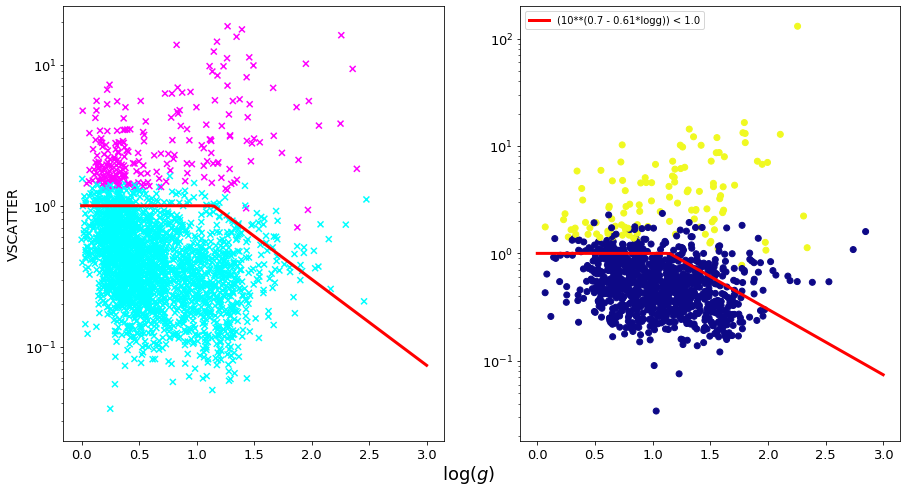

In [15]:
fig, ax = plt.subplots(1, 2,figsize=(15,8))
logg = np.linspace(0,3,100)

foo = [(10**(c1 + c2*lg)) if (10**(c1 + c2*lg)) < 1.0 else 1.0 for lg in logg]

ax[0].scatter(lmc['LOGG'], lmc['VSCATTER'], c = detection_list, marker = 'x', cmap='cool')
ax[0].set_yscale("log")
ax[0].plot(logg, foo, lw = 3, label ="(10**({} - {}*logg)) < 1.0".format(c1, -c2), c = 'r')

ax[1].scatter(smc['LOGG'], smc['VSCATTER'], c = detection_list2, marker='o', cmap='plasma', label = None)
ax[1].set_yscale('log')
ax[1].plot(logg, foo, lw = 3, label ="(10**({} - {}*logg)) < 1.0".format(c1, -c2), c = 'r')


ax[1].legend()
ax[0].set_ylabel("VSCATTER", size = 14)
fig.text(0.5, 0.06, "$\log(g)$", ha='center', size = 18)
fig.savefig("r13-detection_scatter.pdf")

In [ ]:
from multiprocessing import Pool
import functools

import imp
imp.reload(bayli)

clist = [0.9, 0.7, 0.5]
pool = Pool()
answer_lmc = pool.map(functools.partial(bayli.likelihood_result,
                                        gal_path="lmc-r13-l33-58672.pck",
                                        c2=-0.7,
                                        mu=3.4,
                                        sigma=2.4,
                                        m_min=150*u.jupiterMass),
                      clist)

Done with, 0 2019-10-02 22:28:33.825880
Done with, 0 2019-10-02 22:28:34.732009
Done with, 0 2019-10-02 22:28:38.094711
Done with, 1 2019-10-02 22:30:50.717246
Done with, 1 2019-10-02 22:30:52.109479
Done with, 1 2019-10-02 22:30:54.889724
Done with, 2 2019-10-02 22:33:36.228839
Done with, 2 2019-10-02 22:33:51.364209
Done with, 2 2019-10-02 22:34:16.109157
Done with, 3 2019-10-02 22:38:17.104013
Done with, 3 2019-10-02 22:38:30.832783
Done with, 3 2019-10-02 22:38:37.610403
Done with, 4 2019-10-02 22:42:07.028520
Done with, 4 2019-10-02 22:42:16.637657
Done with, 4 2019-10-02 22:42:37.679885
Done with, 5 2019-10-02 22:46:31.176530
Done with, 5 2019-10-02 22:46:37.717061
Done with, 5 2019-10-02 22:46:40.574814
Done with, 6 2019-10-02 22:52:31.708664
Done with, 6 2019-10-02 22:52:34.973982
Done with, 6 2019-10-02 22:52:38.602528
Done with, 7 2019-10-02 22:57:44.757652
Done with, 7 2019-10-02 22:57:54.693658
Done with, 7 2019-10-02 22:58:07.311385
Done with, 8 2019-10-02 23:03:39.765853


In [9]:
pool = Pool()
answer_smc = pool.map(functools.partial(bayli.likelihood_result,
                                        gal_path="smc-r13-l33-58672.pck",
                                        c2=-0.7,
                                        mu=3.4,
                                        sigma=2.4,
                                        m_min=150*u.jupiterMass),
                      clist)

Done with, 0 2019-09-09 22:38:53.863762
Done with, 0 2019-09-09 22:39:09.038666
Done with, 0 2019-09-09 22:39:10.951159
Done with, 1 2019-09-09 22:40:03.832477
Done with, 1 2019-09-09 22:40:22.491320
Done with, 1 2019-09-09 22:40:40.463455
Done with, 2 2019-09-09 22:41:08.250147
Done with, 2 2019-09-09 22:42:09.241635
Done with, 2 2019-09-09 22:42:25.729989
Done with, 3 2019-09-09 22:42:34.035061
Done with, 3 2019-09-09 22:43:25.256810
Done with, 4 2019-09-09 22:44:20.506731
Done with, 3 2019-09-09 22:44:29.789256
Done with, 4 2019-09-09 22:45:46.637579
Done with, 5 2019-09-09 22:45:57.416912
Done with, 4 2019-09-09 22:46:51.616352
Done with, 6 2019-09-09 22:47:47.603184
Done with, 5 2019-09-09 22:48:26.542086
Done with, 5 2019-09-09 22:49:05.495642
Done with, 7 2019-09-09 22:50:46.123673
Done with, 6 2019-09-09 22:51:01.356146
Done with, 6 2019-09-09 22:51:17.198519
Done with, 7 2019-09-09 22:53:07.101935
Done with, 8 2019-09-09 22:54:10.022803
Done with, 7 2019-09-09 22:54:27.691480


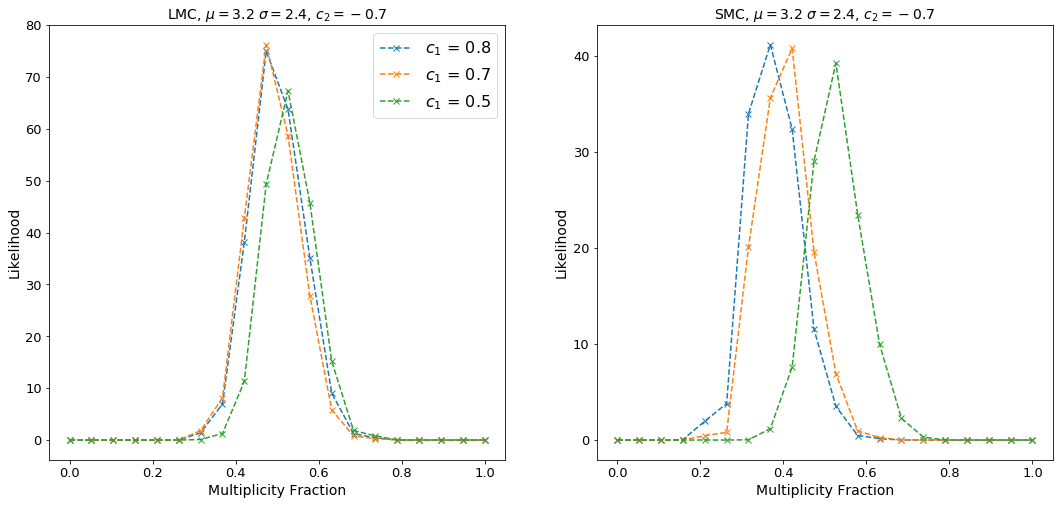

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (18,8))
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)
for n in range(len(clist)):
    ax[0].plot(np.linspace(0,1,20),np.exp(answer_lmc[n]), 'x--', label = '$c_1$ = {}'.format(clist[n]))
for n in range(len(clist)):
    ax[1].plot(np.linspace(0,1,20),np.exp(answer_smc[n]), 'x--', label = '$c_1$ = {}'.format(clist[n]))

ax[0].legend(prop = {'size': 16})
ax[0].set_title('LMC, $\mu = 3.2$ $\sigma = 2.4$, $c_2 = -0.7$', size = 14)
ax[0].set_xlabel("Multiplicity Fraction", size = 14)
ax[0].set_ylabel("Likelihood", size = 14)

ax[1].set_title('SMC, $\mu = 3.2$ $\sigma = 2.4$, $c_2 = -0.7$', size = 14)
ax[1].set_xlabel("Multiplicity Fraction", size = 14)
ax[1].set_ylabel("Likelihood", size = 14)

# fig.suptitle("Likelihood for LMC and SMC r12-beta", size = 16, y = 0.95)
fig.savefig('r13-binary-fraction_{}.pdf'.format(dt.datetime.now()))
plt.show()

In [9]:
import imp
imp.reload(bayli)
bayli.mcmc_likelihood(lmc, , 4, 10, "LMC_MCMC_MultiplicityOnly.pck",3,
                     3.1, 2.7, c1, c2)

100%|██████████| 10/10 [04:14<00:00, 25.90s/it]


Serial took 279.8 seconds


In [ ]:
import imp
imp.reload(bayli)
bayli.mcmc_likelihood(lmc, 2, 10, 100, "LMC_MCMC_MultiplicityOnly.pck",50,
                     3.1, 2.7, c2)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\cody2\Anaconda3\lib\site-packages\emcee\moves\red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 10%|█         | 10/100 [47:29<6:43:36, 269.07s/it]

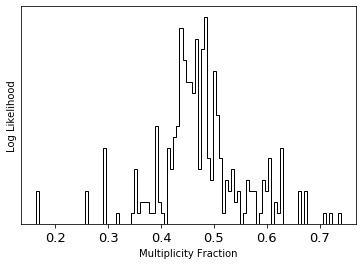

In [37]:
samples = rick.load(open("LMC_MCMC_MultiplicityOnly.pck", "rb"))
samples = samples.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel("Multiplicity Fraction")
plt.ylabel("Log Likelihood")
plt.gca().set_yticks([]);

In [38]:
rick.dump([])

AttributeError: 'numpy.ndarray' object has no attribute 'get_chain'